# Ejercicio 1

## Adquisición  de datos

In [405]:
import pandas as pd
datos_raw = pd.read_csv("data/diabetes.csv")
# print(datos_raw)

## Pre-procesamiento de datos

### Indagación de datos

In [406]:
# Indagacion de los datos
# Analizo los datos en busca de ceros y faltantes
import numpy as np

caracteristicas = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI','DiabetesPedigreeFunction']
cuenta = 0
for caract in caracteristicas:
    descriptor = datos_raw[caract].describe()
    cuenta_de_valores = datos_raw[caract].value_counts()
    cantidad_ceros = cuenta_de_valores[0] if 0 in cuenta_de_valores else 0
    cuenta += cantidad_ceros
    print(f'cantidad de ceros en {caract}: {cantidad_ceros}')

print(f'cuenta:{cuenta}')


cantidad de ceros en Glucose: 5
cantidad de ceros en BloodPressure: 35
cantidad de ceros en SkinThickness: 227
cantidad de ceros en Insulin: 374
cantidad de ceros en BMI: 11
cantidad de ceros en DiabetesPedigreeFunction: 0
cuenta:652


### Tratamiento de nulos

Dado que existe una cantidad significativa de ceros, y considerando que 
representan una variable no medida, los paso a NaN para que no sean considerados 
en los promedios y otros calculos

In [407]:
# Asumo que los valores nulos de `caracteristicas` no fueron medidos y los convierto a NaN
for caract in caracteristicas:
    datos_raw[caract].replace([0, 0.0], np.NaN, inplace=True)    


Se decide avanzar eliminando las filas con datos faltantes

In [408]:
# Se prueba eliminando todas las filas que contengan algun NaN
datos_sin_nan = datos_raw.dropna(subset=caracteristicas).reset_index()
print(f"Cantidad de registros incluyendo NaN: {datos_raw['Pregnancies'].count()}")
print(f"Cantidad de registros sin incluir NaN: {datos_sin_nan['Pregnancies'].count()}")

Cantidad de registros incluyendo NaN: 768
Cantidad de registros sin incluir NaN: 392


### Categorización de características

#### Criterios usados

Se generaran las categorías según dos criterios y luego se evaluará sus resultados.

1. Según ***media***: se generan 3 intervalos en función de la media +- la desviación estandar. La media se toma sólo de los casos de personas no diabéticas (`casos_negativos`), para que las etiquetas representen los valores de gente sana. Los intervalos configuran las categorías 0, 1 y 2 que representarían valores "bajo", "medio" y "alto".

2. Según ***cuantiles***: se generan `CANTIDAD_DE_INTERVALOS` cuantiles en función de mantener balanceada la cantidad de muestras.

Es de esperar que el criterio según cuantiles tenga mejor rendimiento ya que manteniendo balanceadas las muestras, se evita el sesgo hacia las clases dominantes.

#### Separación de datasets

In [409]:
# Voy a categorizar en funcion de los casos sin diabetes (casos negativos)
casos_negativos = datos_sin_nan.sort_values(by='Outcome')
cantidad_casos_negativos = casos_negativos['Outcome'].value_counts(sort=False,ascending=True)[0]
casos_negativos = casos_negativos[:cantidad_casos_negativos]

datos_segun_media = datos_sin_nan.copy()
datos_segun_cuantiles = datos_sin_nan.copy()

#### Categorización de `Age`

La edad se categoriza según la recomendación del enunciado

In [410]:
# Pre-procesamiento de datos. Categorizacion de 'Age'
def mapearEdades(edad):
    if (edad >= 0 and edad <= 11): return "0" # 'niño'
    elif (edad >= 12 and edad <= 18): return "1" # 'adolescente'
    elif (edad >= 19 and edad <= 25): return "2" # 'joven'
    elif (edad >= 26 and edad <= 59): return "3" # 'adulto'
    elif (edad >= 60 and edad <= 70): return "4" # 'mayor'
    
datos_segun_media['Age'] = datos_segun_media['Age'].apply(mapearEdades)
datos_segun_cuantiles['Age'] = datos_segun_cuantiles['Age'].apply(mapearEdades)


#### Categorización de `Glucose`, `BloodPressure`, `SkinThickness`, `BMI`, `DiabetesPedigree`, `Insulin`

##### Segun media

In [411]:
# Categorizo el resto de las caracteristicas segun el descriptor de la gente sana
intervalos_medias = {}
for caract in caracteristicas:
    descriptor = casos_negativos[caract].describe()
    # print(descriptor)
    intervalos = [
        descriptor['min'], 
        descriptor['mean'] - descriptor['std'], 
        descriptor['mean'] + descriptor['std'], 
        descriptor['max']
        ]
    print(f'intervalos: {intervalos}')
    etiquetas = [0, 1, 2]
    intervalos_medias[caract] = intervalos
    
    datos_segun_media[caract] = pd.cut(datos_segun_media[caract], bins=intervalos, labels=etiquetas)

intervalos: [56.0, 86.78916457351355, 136.0734308463338, 197.0]
intervalos: [24.0, 57.076624226048935, 80.862307071661, 106.0]
intervalos: [7.0, 16.81777379332741, 37.68604300056572, 60.0]
intervalos: [15.0, 28.22878515166022, 233.4811385124619, 744.0]
intervalos: [18.2, 24.955792588603, 38.54573412895425, 57.3]
intervalos: [0.085, 0.1729282343344145, 0.771407643528181, 2.329]


##### Segun cuantiles

In [412]:

CANTIDAD_CATEGORIAS = 3
etiquetas = [cat for cat in range(CANTIDAD_CATEGORIAS)]
intervalos_cuantiles = {}

for caract in caracteristicas:
    # print(caract)
    datos_segun_cuantiles[caract], intervalos_q = pd.qcut(
        x=datos_segun_cuantiles[caract], 
        q=CANTIDAD_CATEGORIAS, 
        labels=etiquetas, 
        retbins=True,
    )
    intervalos_cuantiles[caract] = intervalos_q
    # print(intervalos_q.shape())

## Modelado y evaluación

### Splitting de datos

In [413]:
from sklearn.model_selection import train_test_split
PORCENTAJE_TESTEO = 0.3

caracteristicas_entrada = [
    # 'Pregnancies', 
    'Glucose',
    'BloodPressure', 
    'SkinThickness', 
    'BMI', 
    'DiabetesPedigreeFunction', 
    'Insulin',
    'Age']
caracteristicas_objetivo = 'Outcome'

X_train, X_test, y_train, y_test = train_test_split(
    datos_segun_media[caracteristicas_entrada],
    datos_segun_media[caracteristicas_objetivo],
    test_size = PORCENTAJE_TESTEO
    )

X_segun_cuantiles_train, X_segun_cuantiles_test, y_segun_cuantiles_train, y_segun_cuantiles_test = train_test_split(
    datos_segun_cuantiles[caracteristicas_entrada],
    datos_segun_cuantiles[caracteristicas_objetivo],
    test_size = PORCENTAJE_TESTEO
    )


In [414]:
# print(datos_segun_cuantiles)
# df = pd.isna(datos_segun_media['Glucose'])
# print(df.where(df == True).count())

### Configuración y entrenamiento del modelo

In [415]:
from unittest import mock
from sklearn import tree

PROFUNDIDAD_ARBOL = 4
CRITERIO_CLASIFICADOR = 'entropy'

arbol_segun_media = tree.DecisionTreeClassifier(criterion=CRITERIO_CLASIFICADOR, max_depth=PROFUNDIDAD_ARBOL)
arbol_segun_cuantiles = tree.DecisionTreeClassifier(criterion=CRITERIO_CLASIFICADOR, max_depth=PROFUNDIDAD_ARBOL)

with mock.patch("sklearn.utils.validation._assert_all_finite"):
    arbol_segun_media.fit(X=X_train, y=y_train)
    arbol_segun_cuantiles.fit(X=X_segun_cuantiles_train, y=y_segun_cuantiles_train)
    
# La idea del mock.patch sirve para omitir la validacón de NaN, ya que tengo valores NaN. Leer Referencia 4
    

### Evaluación del modelo

In [416]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

# Analizar modelo
predicciones_segun_media = []
predicciones_segun_cuantiles = []

with mock.patch("sklearn.utils.validation._assert_all_finite"):
    predicciones_segun_media = arbol_segun_media.predict(X=X_test)
    predicciones_segun_cuantiles = arbol_segun_cuantiles.predict(X=X_segun_cuantiles_test)

matriz_confusion_segun_media = confusion_matrix(y_true=y_test, y_pred=predicciones_segun_media)
matriz_confusion_segun_cuantiles = confusion_matrix(y_true=y_segun_cuantiles_test, y_pred=predicciones_segun_cuantiles)


#### Visualización de resultados

##### Matriz de confusión

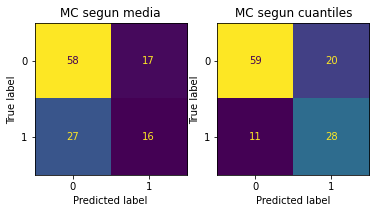

In [417]:
plt.figure()

widget_matriz_confusion_segun_media = ConfusionMatrixDisplay(
    confusion_matrix=matriz_confusion_segun_media,
    display_labels=arbol_segun_media.classes_
    )
widget_matriz_confusion_segun_media.plot(ax=plt.subplot(121), colorbar=False)
plt.title('MC segun media')

widget_matriz_confusion_segun_cuantiles = ConfusionMatrixDisplay(
    confusion_matrix=matriz_confusion_segun_cuantiles,
    display_labels=arbol_segun_cuantiles.classes_,
    )
widget_matriz_confusion_segun_cuantiles.plot(ax=plt.subplot(122), colorbar=False)
plt.title('MC segun cuantiles')

plt.show()

In [427]:
# Obtener los datos relevantes de las MC
matrices_confusion = [matriz_confusion_segun_media, matriz_confusion_segun_cuantiles]
parametros_mc = {}

for index, mc in enumerate(matrices_confusion):
    params = {}
    params['Predicciones correctas'] = mc[0][0] + mc [1][1]
    params['Predicciones incorrectas'] = mc[0][1] + mc [1][0]
    params['Predicciones totales'] = params['Predicciones correctas'] + params['Predicciones incorrectas']
    params['Predicciones correctas (%)'] = f"{(params['Predicciones correctas'] / params['Predicciones totales']):.2f}"
    params['Predicciones incorrectas (%)'] = f"{(params['Predicciones incorrectas'] / params['Predicciones totales']):.2f}"
    
    parametros_mc[index] = params
    
print('Segun Media:')
print(parametros_mc[0])
print('Segun Cuantiles:')
print(parametros_mc[1])

Segun Media:
{'Predicciones correctas': 74, 'Predicciones incorrectas': 44, 'Predicciones totales': 118, 'Predicciones correctas (%)': '0.63', 'Predicciones incorrectas (%)': '0.37'}
Segun Cuantiles:
{'Predicciones correctas': 87, 'Predicciones incorrectas': 31, 'Predicciones totales': 118, 'Predicciones correctas (%)': '0.74', 'Predicciones incorrectas (%)': '0.26'}


##### Arbol de decisión

In [418]:
from matplotlib import image as pltimg
from matplotlib import pyplot as plt
import pydotplus
from datetime import datetime

def generarTimestamp():
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    return timestamp

def generarRutaSalida(criterio, timestamp):
        filename=f'output\ejercicio1-segun_{criterio}_{timestamp}'
        return filename

def exportarAImagen(arbol, criterio, timestamp):
    def exportarIntervalos(criterio, ruta_salida):
        ruta = f'{ruta_salida}.txt'
        with open(ruta, 'x') as file:
            if (criterio == 'media'):
                file.write(str(intervalos_medias))
            elif (criterio == 'cuantiles'):
                file.write(str(intervalos_cuantiles))
        
    ruta_sin_extension = generarRutaSalida(criterio, timestamp)
    exportarIntervalos(criterio, ruta_sin_extension)
    data = tree.export_graphviz(arbol, feature_names=caracteristicas_entrada,out_file=None)
    graph = pydotplus.graph_from_dot_data(data)
    graph.write_png(f'{ruta_sin_extension}.png')
    
    return f'{ruta_sin_extension}.png'

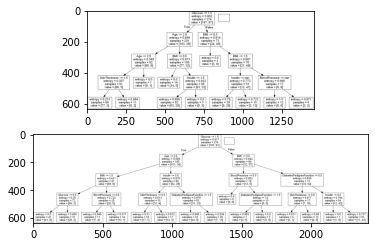

In [419]:
tiempo = generarTimestamp()
plt.figure()

ruta_img_segun_media = exportarAImagen(arbol_segun_media, 'media', tiempo)
plt.subplot(211)
img_media = pltimg.imread(ruta_img_segun_media)
imgplot = plt.imshow(img_media)

ruta_img_segun_cuantiles = exportarAImagen(arbol_segun_cuantiles, 'cuantiles', tiempo)
plt.subplot(212)
img_cuantiles = pltimg.imread(ruta_img_segun_cuantiles)
imgplot_cuantiles = plt.imshow(img_cuantiles)

plt.show()

## Conclusiones

## Referencias

1. <https://scikit-learn.org/stable/modules/tree.html>

2. <https://pandas.pydata.org/docs/user_guide/index.html>

3. <https://www.markdownguide.org/basic-syntax/>

4. <https://stackoverflow.com/a/70881977>

5. <https://matplotlib.org/3.5.0/tutorials/introductory/pyplot.html>